# Natural Language Processing
[Slides](https://docs.google.com/presentation/d/1n0sppuB6w4ow2y3enpakBRs4sVLUteTRIDpcP4IUnG0/edit?usp=sharing)

## Imports

In [0]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from keras.datasets import imdb

from keras.preprocessing.text import Tokenizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

## 20 News Groups

In [0]:
news = fetch_20newsgroups()

In [0]:
X = news.data
y = news.target

In [0]:
print(X[0])
print("###############")
print(X[1])

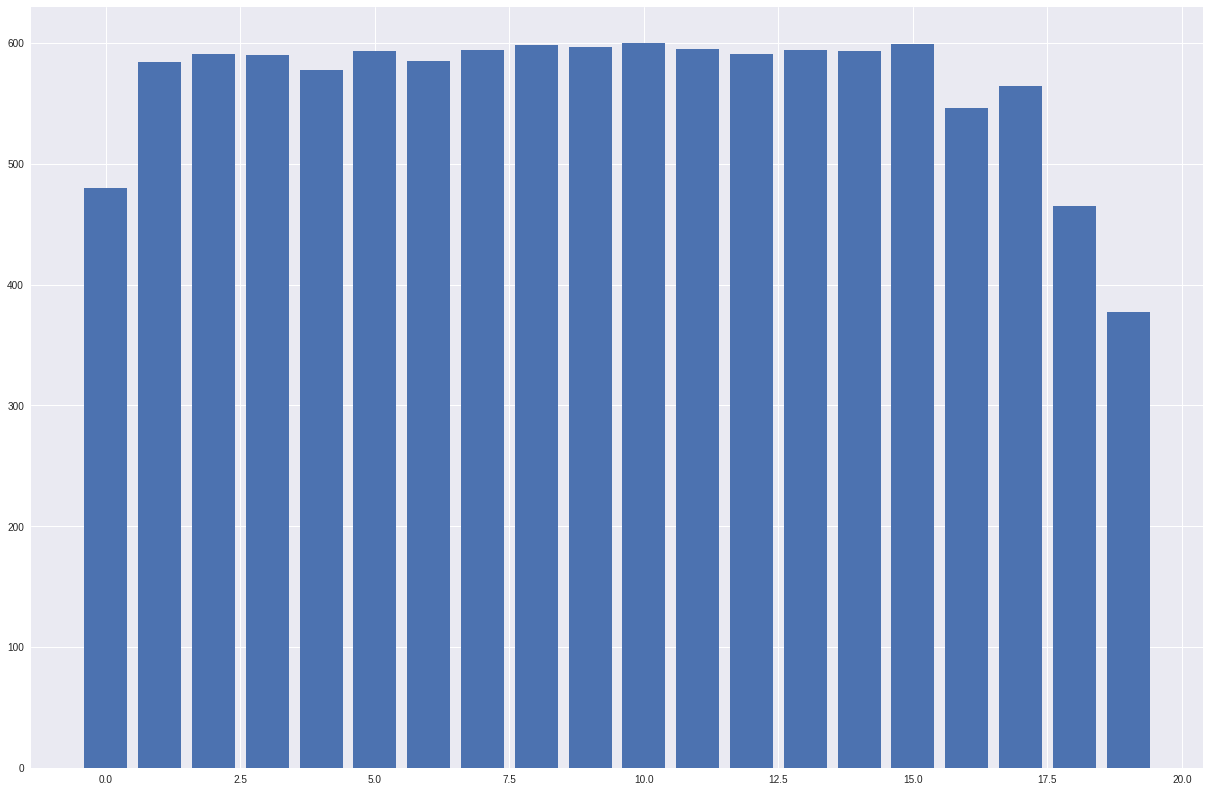

In [7]:
plt.bar(np.arange(len(np.unique(y))), np.unique(y, return_counts=True)[1])
plt.gcf().set_size_inches(21, 14)

## Text Preprocessing

Text data can come in different shapes and sizes. To 'normalize' the data to make it more usable in our models we need to clean it by removing punctuation, link, removing duplicate spaces, removing newline characters, make everything lowercase.


Check this article for more information:
 - https://machinelearningmastery.com/clean-text-machine-learning-python/
 

In [0]:
import re
import nltk
import string

def clean(text):
    text = re.sub('<[^<]+?>', ' ', text)
 
    text = text.replace('\\"', '')
 
    text = text.replace('\n', ' ')
  
    text = text.replace('\t', ' ')

    text = text.replace('"', '')
      
    text = text.translate(str.maketrans('', '', string.punctuation))

    text = re.sub(' +', ' ', text)
    
    text = re.sub('\d+', '0', text)
    
    text = text.lower()
    
    
    return text

In [0]:
clean(X[0])

# Bag of Words

Bag of words model is a way to encode each of our documents as a set of numbers. These numbers represent if a word from the vocabulary is present in the document or not.

Check these links to find out more:
- https://machinelearningmastery.com/gentle-introduction-bag-words-model/
- https://medium.com/greyatom/an-introduction-to-bag-of-words-in-nlp-ac967d43b428


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

In [0]:
vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'), min_df=3, max_features=100)

X_train_onehot = vectorizer.fit_transform([clean(x) for x in X]).todense()


In [0]:
X_train_onehot.shape

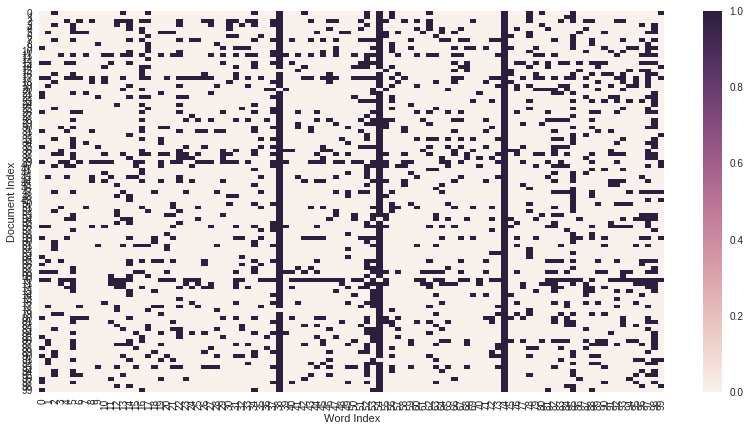

In [13]:
sns.heatmap(X_train_onehot[:100, :])

ax = plt.gca()

ax.set_xlabel('Word Index')
ax.set_ylabel('Document Index')

plt.gcf().set_size_inches(14, 7)

This image is a showing for a particular document (y axis), what words appear in it. Only "important" words are taken into account, that have the highest term frequency.



## Feed-Forward Neural Network on Bag of Words

In [0]:
vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'), max_features=5000)
X_train_onehot = vectorizer.fit_transform([clean(x) for x in X]).todense()

x_train, x_test, y_train, y_test = train_test_split(X_train_onehot, y, random_state=42)

In [0]:
x_train.shape, y_train.shape

In [0]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(64, activation='relu', input_shape=(x_train.shape[-1], )))
model.add(keras.layers.Dense(32, activation='relu'))

model.add(keras.layers.Dense(len(np.unique(y)), activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

In [0]:
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data = (x_test, y_test))

The network is overfitting. What can we do to prevent this?

## Feed-Forward Neural Network with Tfidf

Tf-idf (term frequency - inverse term frequency) is another way to encode our documents, but takes into account frequent words and infrequent words. 

Single-page tutorial: 
 - http://www.tfidf.com/

Check out this plot to understand more about the intuition:

![](https://cdn-images-1.medium.com/max/1200/1*_OsV8gO2cjy9qcFhrtCdiw.jpeg)

In [0]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), max_features=100)

In [0]:
X_train_tfidf = vectorizer.fit_transform([clean(x) for x in X]).todense()

In [0]:
X_train_tfidf.shape

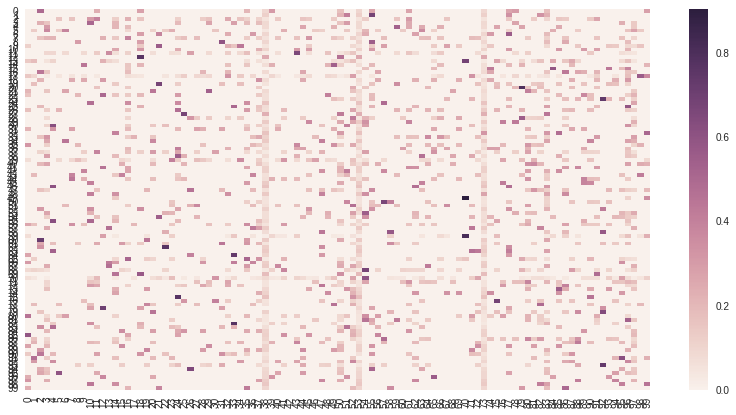

In [21]:
sns.heatmap(X_train_tfidf[:100, :])

plt.gcf().set_size_inches(14, 7)

In [0]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), max_features=5000)
X_train_tfidf = vectorizer.fit_transform([clean(x) for x in X]).todense()


model = keras.models.Sequential()
model.add(keras.layers.Dense(64, input_shape=(5000, ), activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(len(np.unique(y)), activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_tfidf, y, epochs=5, validation_split=0.2)

## Calculating similarity between documents

![](https://cdn-images-1.medium.com/max/800/0*XMW5mf81LSHodnTi.png)

In [0]:
docs = [X[i] for i in np.argwhere(y == 0).ravel()]

doc_vector = vectorizer.transform([clean(docs[0])])
doc_vector2 = vectorizer.transform([clean(docs[1])])

print(docs[0])
print('#########################')
print(docs[1])

print(cosine_similarity(doc_vector.reshape(1, -1), doc_vector2.reshape(1, -1)))



In [0]:
docs = [X[i] for i in np.argwhere(y == 0).ravel()]
docs2 = [X[i] for i in np.argwhere(y == 1).ravel()]

doc_vector = vectorizer.transform([clean(docs[0])])
doc_vector2 = vectorizer.transform([clean(docs2[0])])

print(docs[0])
print('#########################')
print(docs2[0])

print(cosine_similarity(doc_vector.reshape(1, -1), doc_vector2.reshape(1, -1)))

### TfIdf only captures syntactic information (occurance of words). Similarity using tfidf between documents is only concerned what words are present, with no semantic meaning.

# Word Embeddings

If we wish to capture some semantic information, we must resort to word embeddings like Word2Vec. These embeddings are learned through a neural network such that they capture information about the relation between words. 

- https://www.tensorflow.org/tutorials/representation/word2vec
- https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa

In [0]:
import gensim

import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [0]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)

In [0]:
cleaned_text = [clean(x).split() for x in X]

In [0]:
w2v_model.build_vocab(cleaned_text, progress_per=1000)

In [0]:
w2v_model.train(cleaned_text, total_examples=w2v_model.corpus_count, epochs=1, report_delay=1)

In [0]:
w2v_model.init_sims(replace=True)

In [0]:
w2v_model.wv.most_similar(["woman"])

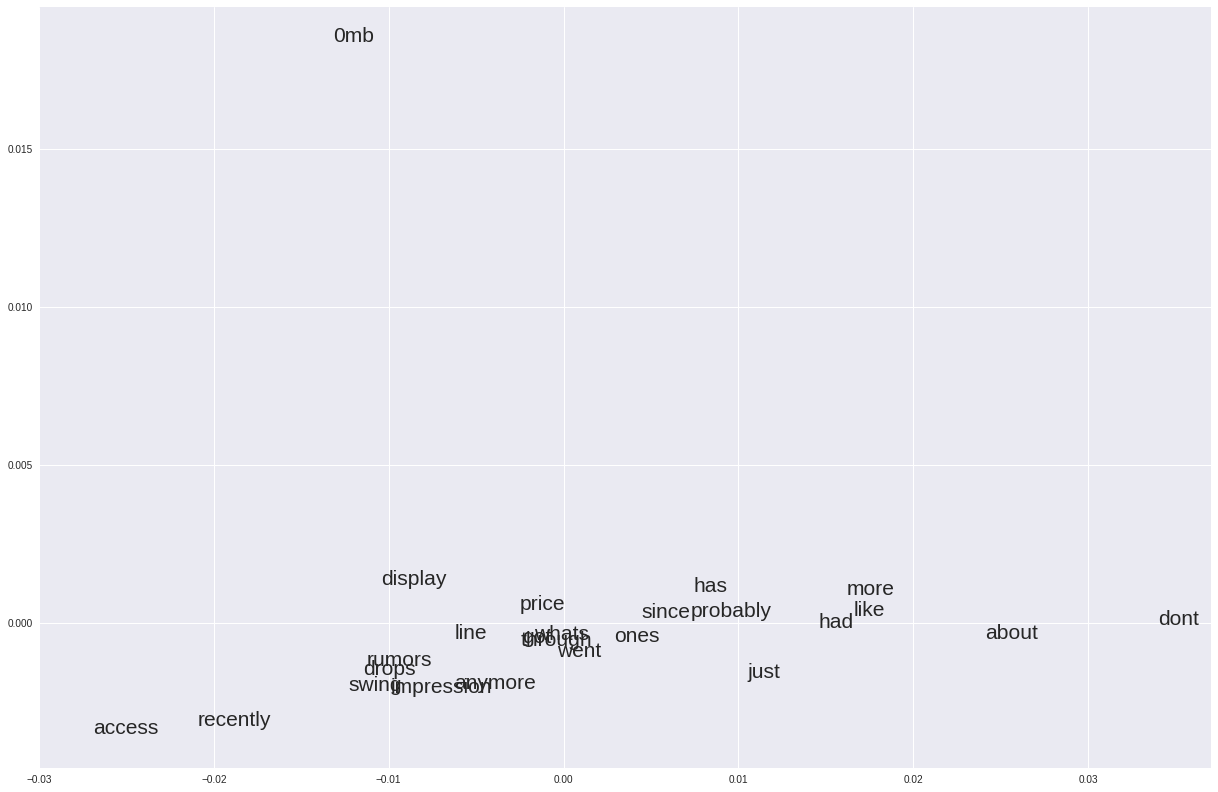

In [32]:
from sklearn.decomposition import PCA
import random

index = random.randint(0, 5000)
index = 200
words = list(w2v_model.wv.vocab.keys())[index: index+25]

pca = PCA(2)

vectors = np.array([w2v_model.wv.get_vector(w) for w in words])

transformed = pca.fit_transform(vectors)

for i, v in enumerate(transformed[:25]):
  plt.text(v[0], v[1], words[i], fontsize=21)

plt.scatter(transformed[:, 0], transformed[:, 1], s=0)
plt.gcf().set_size_inches(21, 14)

In [0]:
def get_sentence_embedding(sentence):
  
  embedding = np.zeros(300)
  
  for word in sentence.split():
    try:
      vector = w2v_model.wv.get_vector(word)
    except KeyError as e:
      vector = np.zeros(300)
    embedding += vector
    
  return embedding / len(sentence.split())
  

In [0]:
x_w2v = np.array([get_sentence_embedding(clean(sentence)) for sentence in X])

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x_w2v, y)

In [0]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(256, activation='relu', input_shape=(300, )))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(len(np.unique(y)), activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model.summary()

In [0]:
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

## LSTM with custom embeddings

Legendary blog post by Andrew Karpathy:
- http://karpathy.github.io/2015/05/21/rnn-effectiveness/


![](https://image.slidesharecdn.com/data2day2016daniel-161006141859/95/natural-language-processing-with-recurrent-neural-networks-15-638.jpg?cb=1475764680)

In [0]:
max_words = 2000
max_len = 150

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(cleaned_text)

sequences = tok.texts_to_sequences(cleaned_text)
sequences_matrix = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len)

In [0]:
sequences_matrix.shape

In [0]:
model = keras.models.Sequential()

model.add(keras.layers.Embedding(max_words, 50, input_length=max_len, input_shape=(max_len, )))

model.add(keras.layers.CuDNNLSTM(128)) # can be replaced with RNN or GRU
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(len(np.unique(y)), activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model.fit(sequences_matrix, y, epochs=5, batch_size=32, validation_split=0.2)

In [0]:
model.layers[0].get_weights()[0][1]

In [0]:

def most_similar(word, weights, amount=10):
  index = tok.word_index[word]
  
  try:
    embedding = weights[index].reshape(1, -1)
  except:
    embedding = weights[0].reshape(1, -1)
  
  sims = cosine_similarity(embedding, weights).ravel()

  indices = np.argsort(sims)[::-1][1:amount+1]
  return [(tok.index_word[i], sims[i]) for i in indices.ravel()]

In [0]:
embedding_layer = model.layers[0].get_weights()[0]

most_similar('man', embedding_layer)

Note that these may or may not mean anything to us. It's what the network decided to learn about these words. Word2Vec can give us semantically similar words because it was trained that way.